# Credit Risk Modelling


Modelling creidt risk has been a well known data science problem. Credit has played a key role in the economy for centuries and some form of credit has existed since the beginning of commerce. I will be using financial lending data from Lending Club to model the credit risk. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. You can read more about their marketplace here.https://www.lendingclub.com/public/how-peer-lending-works.action.

Investors main concern is to receive an interest on the returns on their investments. Qualified investor can browse loans, purpose of loan and credit scores of borrowers. Once loan is fully, borrower receive the money less Lending Club transaction fee.

Credit modelling on the investors end need to be more rigourous to define with higher probability loans that will be defaulted on and those that will be paid back in full. Higher interest on loans equates to higher returns with the added risk of weak financial history of the borrower.

The model with be under the assumption that the investor is conservative risk-appetiite.

We will further benchmark this against S&P 500 and MSCI World index in terms of Year-on-Year(YoY)

# Data Cleaning

Lending Club data is formatted in csv format along with a data dictionary concerning the columns names. **LoanStats** sheet only concerns us as **RejectStats** are not available for investment. 

### Goal - Build a ML model to accurately predict if a borrower will pay loan on time( or not)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Using style fivethirtyeight
# plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

loans_2019 = pd.read_csv("LoanStats_2019Q1.csv")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,123,124,125,128,129,130,133,138,139,140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
loans_2019.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=144)

In [3]:
loans_2019.shape

(115679, 144)

In [4]:
loans_2019.isnull().sum()

id                                            115677
member_id                                     115679
loan_amnt                                          4
funded_amnt                                        4
funded_amnt_inv                                    4
term                                               4
int_rate                                           4
installment                                        4
grade                                              4
sub_grade                                          4
emp_title                                      19522
emp_length                                     11105
home_ownership                                     4
annual_inc                                         4
verification_status                                4
issue_d                                            4
loan_status                                        4
pymnt_plan                                         4
url                                           

Dropping columns that are 50% empty and above as they have no use.

In [5]:
for col in loans_2019.columns:
    if loans_2019[col].isna().sum() > ((loans_2019.shape[0])/2):
        loans_2019.drop(labels = col, axis=1,inplace=True)
        
        
loans_2019.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       ...
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag'],
      dtype='object', length=101)

There are 101 columns dropped from 141 that we are left with. 
* Ensure that none of the features leak information about that future. 
* Badly formatted rows that need to be cleaned up
* Require more infor to process to be useful to a important feature
* Reduce Redundant Information

There are 4 columns with  around 10% of its rows which are empty, lets look at these columns and see what we can do with them and what they represent.

emp_length                    11105
mths_since_recent_inq         14361
il_util                       17323
emp_title                     19522

**emp_length** indicates the the duration by which the borrower is in the job. Borrower might be self-employed or transitioning between jobs or homeless. Perhaps switching to a categorical format might be better by creating dummy values

**il_uti** indiciates the ratio of total current balance to high credit/credit limit on all install acct. It is a indicator to show the capability of the borrowers to return the money.

**emp_title** might be useful a predictor to determine if a person job title will return their loans. Extensive preprocesing required.
**funded_amnt** :  leaks data about the future
**funded_amnt_inv** : leaks information about the future
**grade** : Same as interest rate, redundant information
**sub_gradee**: Same info as interest rate column
**issue_d**: More information was leaked whether the loan is completely funded

In [6]:
loans_2019['emp_length'].value_counts(dropna=False)

10+ years    34490
< 1 year     15044
NaN          11105
2 years       9695
3 years       8719
1 year        7919
5 years       7189
4 years       6777
6 years       4636
7 years       3913
8 years       3625
9 years       2567
Name: emp_length, dtype: int64

In [7]:
to_drop_col = ['funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d']

clean_loans_2019 = loans_2019.drop(columns = to_drop_col,axis=1)

**zip_code**: redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)
**out_prncp**: leaks data from the future, (after the loan already started to be paid off)
**out_prncp_inv**: also leaks data from the future, (after the loan already started to be paid off)
**total_pymnt**: also leaks data from the future, (after the loan already started to be paid off)
**total_pymnt_inv**: also leaks data from the future, (after the loan already started to be paid off)
**total_rec_prncp**: also leaks data from the future, (after the loan already started to be paid off)

The **out_prncp** and **out_prncp_inv** both describe the outstanding principal amount for a loan, which is the remaining amount the borrower still owes. These 2 columns as well as the **total_pymnt** column describe properties of the loan after it's fully funded and started to be paid off. This information isn't available to an investor before the loan is fully funded thus it would not be an avaiable feature. 

In [8]:
clean_loans_2019.isnull().sum()[:30]

loan_amnt                  4
term                       4
int_rate                   4
installment                4
emp_length             11105
home_ownership             4
annual_inc                 4
verification_status        4
loan_status                4
pymnt_plan                 4
purpose                    4
title                      4
zip_code                   4
addr_state                 4
dti                      261
delinq_2yrs                4
earliest_cr_line           4
inq_last_6mths             4
open_acc                   4
pub_rec                    4
revol_bal                  4
revol_util               133
total_acc                  4
initial_list_status        4
out_prncp                  4
out_prncp_inv              4
total_pymnt                4
total_pymnt_inv            4
total_rec_prncp            4
total_rec_int              4
dtype: int64

In [9]:
to_drop_2 = ['zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv']

clean_loans_2019.drop(to_drop_2,axis=1,inplace=True)


In [10]:
clean_loans_2019.isnull().sum()

loan_amnt                         4
term                              4
int_rate                          4
installment                       4
emp_length                    11105
home_ownership                    4
annual_inc                        4
verification_status               4
loan_status                       4
pymnt_plan                        4
purpose                           4
title                             4
addr_state                        4
dti                             261
delinq_2yrs                       4
earliest_cr_line                  4
inq_last_6mths                    4
open_acc                          4
pub_rec                           4
revol_bal                         4
revol_util                      133
total_acc                         4
initial_list_status               4
total_rec_prncp                   4
total_rec_int                     4
total_rec_late_fee                4
recoveries                        4
collection_recovery_fee     

**total_rec_int** : leaks info when the loan already started to be paid off

**total_rec_late_fee** : leaks info when the loan already started to be paid off

**recoveries** : leaks info when the loan already started to be paid off

**collection_recovery_fee** : leaks info when the loan already started to be paid off

**last_pymnt_d** : leaks info when the loan already started to be paid off

**last_pymnt_amnt** : leaks info when the loan already started to be paid off


In [11]:
to_drop_3 = ['total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt']

clean_loans_2019.drop(columns = to_drop_3,axis=1,inplace=True)

clean_loans_2019.isnull().sum()

loan_amnt                         4
term                              4
int_rate                          4
installment                       4
emp_length                    11105
home_ownership                    4
annual_inc                        4
verification_status               4
loan_status                       4
pymnt_plan                        4
purpose                           4
title                             4
addr_state                        4
dti                             261
delinq_2yrs                       4
earliest_cr_line                  4
inq_last_6mths                    4
open_acc                          4
pub_rec                           4
revol_bal                         4
revol_util                      133
total_acc                         4
initial_list_status               4
total_rec_prncp                   4
next_pymnt_d                   4910
last_credit_pull_d                6
collections_12_mths_ex_med        4
policy_code                 

Columns length drop from 141 to 84. Base on what we want to predict, we should use 'loan_status' as the target column that we want to predict. [Loan Status Information](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-).

Base on the link, we only want to predict loans that are paid off on time. This is represented by 'Fully Paid' or 'Charged Off' values. 'Charged Off' status represents loans that have no chance of being repaid.

Treating this problem as a **binary classification** problem. We are going to remove all loans that dont contain either 'Fully Paid' or 'Charged Off'

To be noted, that is significant **class imbalance** between positive and negative cases. 4730 have been fully paid off while only 176 were charged off, a ratio of 26.85:1

Dropping 'loan_status' values that are not either 'Fully Paid' or 'Charged Off'

In [12]:
clean_loans_2019['loan_status'].value_counts()
clean_loans_2019.shape

(115679, 84)

In [13]:
clean_loans_2019 = clean_loans_2019[(clean_loans_2019['loan_status'] == 'Fully Paid') | (clean_loans_2019['loan_status'] == 'Charged Off')]

loan_status_mapping = {'loan_status':{'Fully Paid':1,"Charged Off":0}}
clean_loans_2019 = clean_loans_2019.replace(loan_status_mapping)


clean_loans_2019['loan_status'].value_counts()
clean_loans_2019.shape

(4906, 84)

# Dropping columns that contain only 1 unique value

In [14]:
orig_columns = clean_loans_2019.columns
drop_columns = []
for col in orig_columns:
    col_series = clean_loans_2019[col].dropna().unique()
    if len(col_series) == 1:
        drop_columns.append(col)
clean_loans_2019 = clean_loans_2019.drop(drop_columns, axis=1)
print(drop_columns)



['pymnt_plan', 'policy_code', 'acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'tax_liens', 'hardship_flag']


There is still to much variance in our data, I'll be removing columns base off a csv from [S3 Link](https://dsserver-prod-resources-1.s3.amazonaws.com/134/filtered_loans_2007.csv?versionId=IimLS4KJWbKE2YbRs642R9IoD1qn20UR) that was used for a similar goal.




In [15]:
cols_to_keep = ['loan_amnt','term','int_rate','installment','emp_length','home_ownership','annual_inc','verification_status','loan_status','purpose','title','addr_state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','last_credit_pull_d','pub_rec_bankruptcies']


clean_loans_2019['pub_rec_bankruptcies'].head(5)

64     0.0
87     0.0
91     0.0
105    0.0
133    0.0
Name: pub_rec_bankruptcies, dtype: float64

In [16]:
filtered_2019 = clean_loans_2019.reindex(cols_to_keep,axis=1)

In [17]:
filtered_2019.shape

(4906, 23)

In [18]:
filtered_2019.isnull().sum().sort_values()

loan_amnt                 0
total_acc                 0
revol_bal                 0
pub_rec                   0
open_acc                  0
inq_last_6mths            0
earliest_cr_line          0
delinq_2yrs               0
last_credit_pull_d        0
title                     0
addr_state                0
loan_status               0
verification_status       0
annual_inc                0
home_ownership            0
installment               0
int_rate                  0
term                      0
purpose                   0
pub_rec_bankruptcies      0
dti                      14
revol_util               14
emp_length              474
dtype: int64

Employment length is frequently used in assessing how risky a potential borrower is, so we'll keep this column despite its relatively large amount of missing values.

In [19]:
filtered_2019.dtypes.value_counts()

object     11
float64    11
int64       1
dtype: int64

We can only work with numerical of categorical columns when peforming ML techniques the need to convert object values to categorical.

In [20]:
object_cols_df = filtered_2019.select_dtypes(include=['object'])
print(object_cols_df.head())

           term int_rate emp_length home_ownership verification_status  \
64    60 months   15.57%  10+ years       MORTGAGE        Not Verified   
87    36 months   17.19%    5 years           RENT     Source Verified   
91    36 months   13.90%  10+ years           RENT        Not Verified   
105   36 months   28.80%        NaN       MORTGAGE            Verified   
133   60 months   12.40%        NaN       MORTGAGE        Not Verified   

                purpose                    title addr_state earliest_cr_line  \
64   debt_consolidation       Debt consolidation         CO           Oct-06   
87   debt_consolidation       Debt consolidation         MO           Jun-06   
91   debt_consolidation       Debt consolidation         NY           Dec-11   
105         credit_card  Credit card refinancing         OH           Apr-90   
133         credit_card  Credit card refinancing         GA           Feb-97   

    revol_util last_credit_pull_d  
64      78.50%             Jun-19  
87

**term** No. of payments on the loan, 36 to 60 months. These are discrete values

**int_rate** Should be a numeric value, omit the % and convert to float

**emp_length** No. of years borrower was employed on application

**home_ownership** Can only exist as 1 of 4 categories, use dummy columns

**verification_status** If income was verified by Lending Club

**purpose** : a cat to provided by borrower for loan req

**title**: loan refinancing

**addr_state** borrower's state of residence

**earliest_cr_line**: Month the borrower earliest reported credit line was opened.

**revol_util ** Utilization rate of credit relative to all credit available. This too should be in numeric value.

**last_credit_pull_d** Most recent month lending club pulled credit from loan

Dates require more feature engineering for my purpose, would be useful to explore these dates in the future



**home_ownership**,**verification_status**,**emp_length**,**term** each contain a few discrete categorical values which can be encoded to dummy variable to keep.

**purpose** and **title** contain overlapping message to bring across. Title can be varied, base on the borrower's phrasing, whilst purpose have a set of pre-defined values, limiting the number of discretionary values.

**emp_length** will be mapped based on the following:

1) **10+ years** we assume that people more than 10 years only work 10 years. Information of value after 10 are not available

2)  **< 1 year** and **n/a** values are assumed to be 0, information about whether they have worked from to 1 to 12 months is not available and we can simply put them in the 1 year category.

Lastly **addr_state**, 49 additional columns are required to be created, making classification much slower. AFter consideration, it will be removed.



In [21]:
filtered_2019['emp_length'].value_counts(dropna=False)

10+ years    1614
< 1 year      512
NaN           474
2 years       414
3 years       363
1 year        345
5 years       288
4 years       254
6 years       208
7 years       183
8 years       154
9 years        97
Name: emp_length, dtype: int64

In [22]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        np.nan: 0
    }
}

In [23]:
filtered_2019.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

In [24]:
col_to_remove = ['last_credit_pull_d','addr_state','title','earliest_cr_line']

filtered_2019.drop(col_to_remove,axis=1,inplace=True)

filtered_2019['int_rate'] = filtered_2019['int_rate'].str.rstrip("%").astype('float')

filtered_2019['revol_util'] = filtered_2019['revol_util'].str.rstrip("%").astype('float')

filtered_2019.replace(mapping_dict,inplace=True)

Creat dummy columns 

In [25]:
dummy_cols = ['home_ownership','verification_status','term','purpose']

dummies = pd.get_dummies(filtered_2019[dummy_cols])

#Concat back actual with dummies

filtered_2019 = pd.concat([filtered_2019,dummies],axis=1)

#Drop columns used to make dummies
filtered_2019 = filtered_2019.drop(dummy_cols,axis=1)

In [26]:
filtered_2019.isnull().sum()

loan_amnt                               0
int_rate                                0
installment                             0
emp_length                              0
annual_inc                              0
loan_status                             0
dti                                    14
delinq_2yrs                             0
inq_last_6mths                          0
open_acc                                0
pub_rec                                 0
revol_bal                               0
revol_util                             14
total_acc                               0
pub_rec_bankruptcies                    0
home_ownership_ANY                      0
home_ownership_MORTGAGE                 0
home_ownership_OWN                      0
home_ownership_RENT                     0
verification_status_Not Verified        0
verification_status_Source Verified     0
verification_status_Verified            0
term_ 36 months                         0
term_ 60 months                   

There is a small sum of the values in revol_util and dti that is empty. Will be checking the distribution to determine to use median or mean for these values

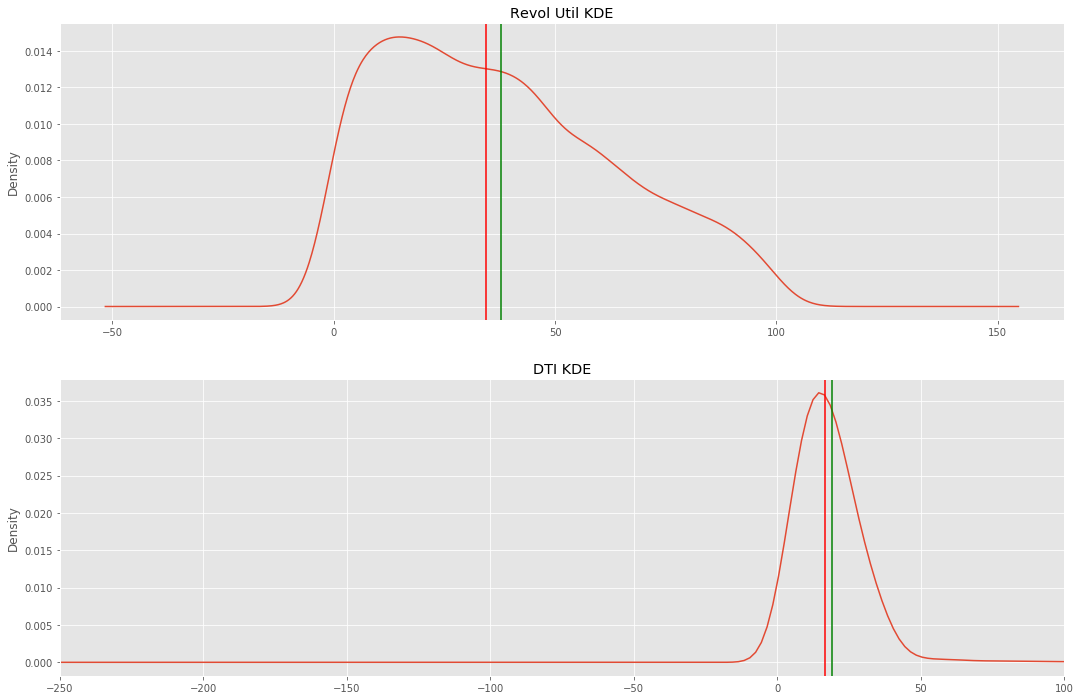

In [27]:
fig= plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(211)



#Revo Util subplots
ax1 = filtered_2019['revol_util'].plot.density()
ax1.axvline(filtered_2019['revol_util'].median(),color= 'r')
ax1.axvline(filtered_2019['revol_util'].mean(),color= 'g')
ax1.title.set_text("Revol Util KDE")

ax2 = fig.add_subplot(212)
#DTI subplots
ax2 = filtered_2019['dti'].plot.density()
ax2.axvline(filtered_2019['dti'].median(),color= 'r')
ax2.axvline(filtered_2019['dti'].mean(),color= 'g')
ax2.set_xlim(-250,100)
ax2.title.set_text("DTI KDE")

plt.show()


Base on the above findings, I will be using the median values to fill the null values in DTI and revol_util

In [28]:
filtered_2019.fillna(np.median,inplace=True)

In [29]:
filtered_2019.to_csv("clean_2019.csv")